
# **KNN and Linear Regression Perfomance Anaylsis on Cifar Dataset**

---




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **The Analysis is divided into sections which shows comprehensive alogorithmic analysis and implementation of:**
1. KNN
2. Linear regression 

# Section 0. Environment Set Up

In [ ]:
!pip install scipy==1.1.0 Pillow==4.3.0

Mount your google drive in google colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Append the directory to your python path using sys

In [ ]:
import sys
prefix = '/content/gdrive/My Drive/'
customized_path_to_your_file = "yourfile_2021"
sys_path = prefix + customized_path_to_your_file
sys.path.append(sys_path)

# Section 1. KNN

In [ ]:
# Run some setup code for this notebook.

from __future__ import print_function
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Get CIFAR10
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 

--2021-02-04 04:59:39--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  66.5MB/s    in 2.4s    

2021-02-04 04:59:41 (66.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


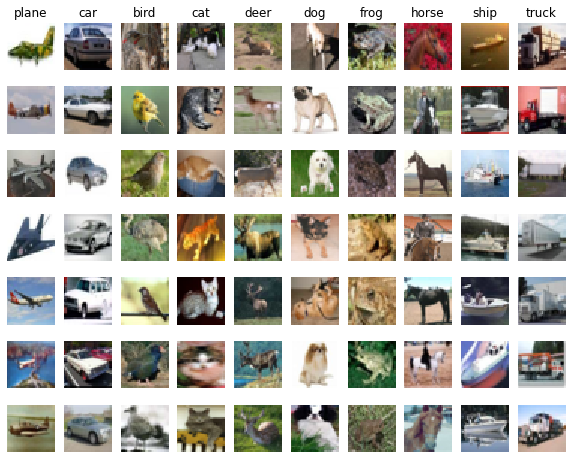

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
          dists[i,j]  = np.sqrt(np.sum(np.square(X[i,:]- self.X_train[j,:])))       
     
    return dists

  def compute_distances_one_loop(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        dists[i,:] = np.sqrt(np.sum(np.square(X[i,:]- self.X_train), axis = 1))
    return dists

  def compute_distances_no_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    dists = np.sqrt(np.sum(X**2,axis=1).reshape(num_test,1)+
                    np.sum(self.X_train**2, axis=1)- 2*X.dot(self.X_train.T))
    pass
    return dists

  def predict_labels(self, dists, k=1):

    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        closest_y = np.take(self.y_train, np.argsort(dists[i]))[:k]
        (values,counts) = np.unique(closest_y, return_counts=True)
        y_pred[i] = values[np.argmax(counts)]
    return y_pred



In [ ]:
# Create a kNN classifier instance. 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.


In [ ]:
# Implement compute_distances_two_loops.
# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


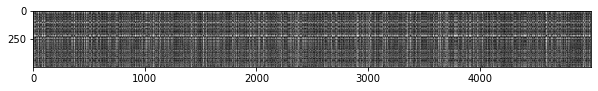

In [ ]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?

*There can be many classes in the training set that was found similar moreover we can say that the classifier got confused may be because of similar bg and classified it into same class*.

- What causes the columns?

*In case of columns there are training examples which are not similar to any of the test example; resulting in higher L2 distance and a white visualization*

In [ ]:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [ ]:
y_test_pred = classifier.predict_labels(dists, k=10)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


### **INSIGHTS**:
We can also try other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if the data is preprocessed by subtracting the mean or the data is preprocessed by subtracting the mean and dividing by the standard deviation.

**WHY SO?:**
Subtracting the mean doesn't affect perfomance as the distance between points remains same because they are shifted in same direction by same amount.

Now lets speed up distance matrix computation by using partial vectorization with one loop. 

In [ ]:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 37.006892 seconds
One loop version took 34.124632 seconds
No loop version took 0.565059 seconds


## Cross-validation:

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

pass

k_to_accuracies = {}
num_set = X_train.shape[0]/num_folds
acc_k = np.zeros((len(k_choices), num_folds), dtype=np.float)


for l, k in enumerate(k_choices):
  for i in range(num_folds):
    X_train = np.concatenate((X_train_folds[:i]+ X_train_folds[i+1:]))
    y_train = np.concatenate((y_train_folds[0:i]+ y_train_folds[i+1:]))
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_train_folds[i], k=k, num_loops=0)
    num_correct = np.sum(y_pred == y_train_folds[i])
    acc_k[l,i] = float(num_correct)/num_set
  k_to_accuracies[k] = acc_k[l]

pass


# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.255000
k = 1, accuracy = 0.252500
k = 1, accuracy = 0.280000
k = 1, accuracy = 0.266250
k = 1, accuracy = 0.266250
k = 3, accuracy = 0.243750
k = 3, accuracy = 0.256250
k = 3, accuracy = 0.238750
k = 3, accuracy = 0.261250
k = 3, accuracy = 0.253750
k = 5, accuracy = 0.226250
k = 5, accuracy = 0.268750
k = 5, accuracy = 0.267500
k = 5, accuracy = 0.260000
k = 5, accuracy = 0.283750
k = 8, accuracy = 0.230000
k = 8, accuracy = 0.283750
k = 8, accuracy = 0.268750
k = 8, accuracy = 0.263750
k = 8, accuracy = 0.271250
k = 10, accuracy = 0.250000
k = 10, accuracy = 0.287500
k = 10, accuracy = 0.281250
k = 10, accuracy = 0.275000
k = 10, accuracy = 0.270000
k = 12, accuracy = 0.250000
k = 12, accuracy = 0.278750
k = 12, accuracy = 0.280000
k = 12, accuracy = 0.258750
k = 12, accuracy = 0.283750
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.276250
k = 15, accuracy = 0.285000
k = 15, accuracy = 0.265000
k = 15, accuracy = 0.286250
k = 20, accuracy = 0.263750
k = 20, accu

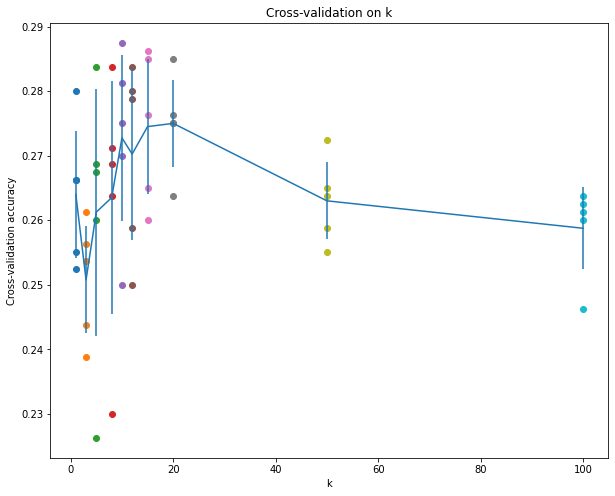

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
best_k = 7

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 143 / 500 correct => accuracy: 0.286000


### **KNN** **INSIGHTS** **ABOUT** **K**:
The training error of a 1-NN will always be better than that of 5-NN because the error can be zero if the training and test data are same.

One more insight is the time needed to classify a test example with the k-NN classifier grows with the size of the training set as KNN sorts the points by distance metrics and does with every point in test data so the time grows as data size grows.

# Section 2. Linear Regression 

## Linear regression with one variable

In [ ]:
prefix = '/content/gdrive/My Drive/'
customized_path_to_your_data = "your_data_2021/data"
data_path = prefix + customized_path_to_your_data + '/ex1data1.txt'
data = np.loadtxt(data_path, delimiter=",") 
m = data.shape[0]                                     
X = data[:,0].reshape(m,1)
y = data[:,1].reshape(m,1)                             

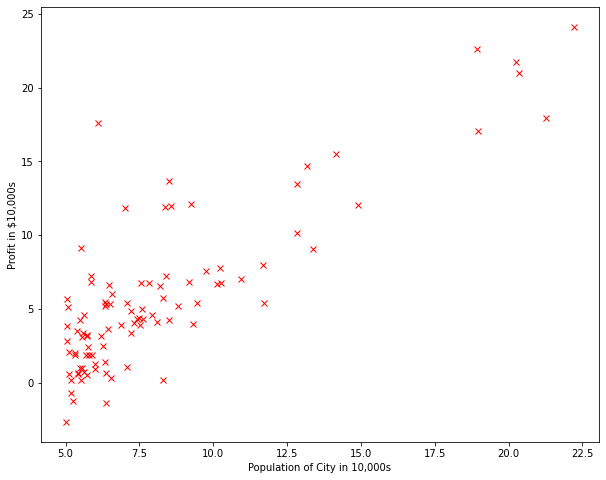

In [ ]:
plt.plot(X,y, 'rx')                         # Plot the data
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.show()

In this part, you will fit the linear regression parameters $\theta$ to our dataset
using gradient descent.

The objective of linear regression is to minimize the cost function
\begin{equation*}
J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2
\end{equation*}


where the hypothesis $h_\theta(x)$ is given by the linear mode
\begin{equation*}
h_{\theta}(x^{(i)}) = \theta^Tx = \theta_0 + \theta_1 x_1
\end{equation*}


Recall that the parameters of your model are the $\theta_j$ values. These are
the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update
\begin{equation*}
\theta_j := \theta_j - \alpha \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)}) x_j^{(i)}
\end{equation*}

With each step of gradient descent, your parameters $\theta_j$ come closer to the
optimal values that will achieve the lowest cost $J(\theta)$.

As you perform gradient descent to learn minimize the cost function J(θ), it is helpful to monitor the convergence by computing the cost. In this section, I implementend a function to calculate J(θ) so you can check the convergence of your gradient descent implementation.


In [ ]:
def compute_cost(X, y, theta):
    m = len(y); # number of training examples
    J = 0;
    hypothesis = np.dot(X, theta)
    J = 1/(2*m)*(np.sum((hypothesis-y)**2)) #finding the cost 
    return J

In [ ]:
X = np.concatenate((np.ones((m, 1)), data[:,0].reshape(m,1)), axis=1)
theta = np.zeros((2, 1)) 

compute_cost(X, y, theta)

32.072733877455676

Keep in mind that the cost J(θ) is parameterized by the vector θ, not X and y. That is, we minimize the value of J(θ) by changing the values of the vector θ, not by changing X or y.

A good way to verify that gradient descent is working correctly is to look at the value of J(θ) and check that it is decreasing with each step. 

In [ ]:
def gradient_descent(X, y, theta, alpha, num_iters):


    # Initialize some useful values
    m = len(y)
    J_history = []

    
    for iter in range(num_iters):
      hypothesis = np.dot(X,theta)
      theta = theta - (alpha/m) * (X.T.dot(hypothesis-y)) 
        # Save the cost J in every iteration 
    J = compute_cost(X, y, theta)
    J_history.append(J)
    
    return theta, J_history

Now let's find the parameter θ and plot the linear fit. 

Running Gradient Descent ...

Theta found by gradient descent: 
[-3.63029144] [1.16636235]


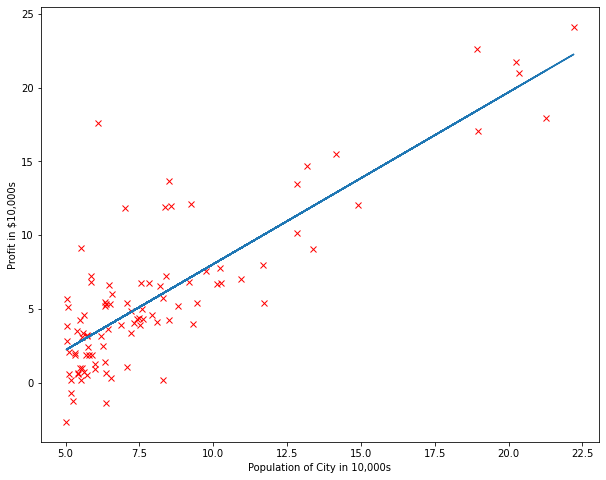

In [ ]:
print('Running Gradient Descent ...\n')

X = np.concatenate((np.ones((m, 1)), data[:,0].reshape(m,1)), axis=1) # Add a column of ones to x
theta = np.zeros((2, 1))                                              # initialize fitting parameters

# Some gradient descent settings
iterations = 1500
alpha = 0.01

# gradient descent
theta, J_history = gradient_descent(X, y, theta, alpha, iterations)
print('Theta found by gradient descent: ')
print(theta[0], theta[1])


plt.plot(X[:,1], y, 'rx')                         # Plot the data
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')

plt.plot(X[:,1], np.dot(X, theta), '-')
plt.show()


## Linear regression with multiple variable

In this part, I implemented linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

The file ex1data2.txt contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price
of the house.

In [ ]:
prefix = '/content/gdrive/My Drive/'
customized_path_to_your_data = "your_2021/data"
data_path = prefix + customized_path_to_your_data + '/ex1data2.txt'
data = np.loadtxt(data_path, delimiter=",") # read comma separated data
m = data.shape[0]                                     # number of training example
X = data[:,0:2].reshape(m,2)
y = data[:,2].reshape(m,1) 
print(X,X.shape) 

[[2.104e+03 3.000e+00]
 [1.600e+03 3.000e+00]
 [2.400e+03 3.000e+00]
 [1.416e+03 2.000e+00]
 [3.000e+03 4.000e+00]
 [1.985e+03 4.000e+00]
 [1.534e+03 3.000e+00]
 [1.427e+03 3.000e+00]
 [1.380e+03 3.000e+00]
 [1.494e+03 3.000e+00]
 [1.940e+03 4.000e+00]
 [2.000e+03 3.000e+00]
 [1.890e+03 3.000e+00]
 [4.478e+03 5.000e+00]
 [1.268e+03 3.000e+00]
 [2.300e+03 4.000e+00]
 [1.320e+03 2.000e+00]
 [1.236e+03 3.000e+00]
 [2.609e+03 4.000e+00]
 [3.031e+03 4.000e+00]
 [1.767e+03 3.000e+00]
 [1.888e+03 2.000e+00]
 [1.604e+03 3.000e+00]
 [1.962e+03 4.000e+00]
 [3.890e+03 3.000e+00]
 [1.100e+03 3.000e+00]
 [1.458e+03 3.000e+00]
 [2.526e+03 3.000e+00]
 [2.200e+03 3.000e+00]
 [2.637e+03 3.000e+00]
 [1.839e+03 2.000e+00]
 [1.000e+03 1.000e+00]
 [2.040e+03 4.000e+00]
 [3.137e+03 3.000e+00]
 [1.811e+03 4.000e+00]
 [1.437e+03 3.000e+00]
 [1.239e+03 3.000e+00]
 [2.132e+03 4.000e+00]
 [4.215e+03 4.000e+00]
 [2.162e+03 4.000e+00]
 [1.664e+03 2.000e+00]
 [2.238e+03 3.000e+00]
 [2.567e+03 4.000e+00]
 [1.200e+03

By looking at the values, note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge much more quickly.

In [ ]:
def feature_normalize(X):
    
    # FEATURENORMALIZE Normalizes the features in X 
    #   FEATURENORMALIZE(X) returns a normalized version of X where the mean value of each
    #   feature is 0 and the standard deviation is 1. This is often a good preprocessing 
    #   step to do when working with learning algorithms.

    X_norm = X
    mu     = 0
    sigma  = 0
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_norm = (X-mu)/sigma
    return X_norm, mu, sigma

print(X,X.shape)

[[2.104e+03 3.000e+00]
 [1.600e+03 3.000e+00]
 [2.400e+03 3.000e+00]
 [1.416e+03 2.000e+00]
 [3.000e+03 4.000e+00]
 [1.985e+03 4.000e+00]
 [1.534e+03 3.000e+00]
 [1.427e+03 3.000e+00]
 [1.380e+03 3.000e+00]
 [1.494e+03 3.000e+00]
 [1.940e+03 4.000e+00]
 [2.000e+03 3.000e+00]
 [1.890e+03 3.000e+00]
 [4.478e+03 5.000e+00]
 [1.268e+03 3.000e+00]
 [2.300e+03 4.000e+00]
 [1.320e+03 2.000e+00]
 [1.236e+03 3.000e+00]
 [2.609e+03 4.000e+00]
 [3.031e+03 4.000e+00]
 [1.767e+03 3.000e+00]
 [1.888e+03 2.000e+00]
 [1.604e+03 3.000e+00]
 [1.962e+03 4.000e+00]
 [3.890e+03 3.000e+00]
 [1.100e+03 3.000e+00]
 [1.458e+03 3.000e+00]
 [2.526e+03 3.000e+00]
 [2.200e+03 3.000e+00]
 [2.637e+03 3.000e+00]
 [1.839e+03 2.000e+00]
 [1.000e+03 1.000e+00]
 [2.040e+03 4.000e+00]
 [3.137e+03 3.000e+00]
 [1.811e+03 4.000e+00]
 [1.437e+03 3.000e+00]
 [1.239e+03 3.000e+00]
 [2.132e+03 4.000e+00]
 [4.215e+03 4.000e+00]
 [2.162e+03 4.000e+00]
 [1.664e+03 2.000e+00]
 [2.238e+03 3.000e+00]
 [2.567e+03 4.000e+00]
 [1.200e+03

Previously, I implemented gradient descent on a univariate regression problem. The only difference now is that there is one more feature in the matrix X. The hypothesis function and the batch gradient descent update
rule remain unchanged.

In [ ]:
X = np.concatenate((np.ones((m, 1)),feature_normalize(data[:,0:2].reshape(m,2))[0]), axis=1)
theta = np.zeros((3, 1)) 

compute_cost(X, y, theta)

65591548106.45744

In [ ]:
def gradient_descent_multi(X, y, theta, alpha, num_iters):
    #GRADIENTDESCENTMULTI Performs gradient descent to learn theta
    #   theta = GRADIENTDESCENTMULTI(x, y, theta, alpha, num_iters) updates theta by
    #   taking num_iters gradient steps with learning rate alpha

    # Initialize some useful values
    m = len(y)
    J_history = []

    
    for iter in range(num_iters):
      hypothesis = np.dot(X,theta)
      theta = theta -alpha*(1/m)*(X.T.dot(hypothesis-y))
      J = compute_cost(X, y, theta)
      print(J)
      J_history.append(J)
    
    return theta, J_history

Now let's find the parameter θ and plot the linear fit.

In [ ]:
alpha = 0.01;
num_iters = 400;

theta = np.zeros((3, 1))
theta, J_history = gradient_descent_multi(X, y, theta, alpha, num_iters)


64297776251.6201
63031018305.52132
61790694237.53249
60576236901.991035
59387091739.9886
58222716488.38939
57082580895.8954
55966166445.97884
54872966086.50778
53802483965.89506
52754235175.605446
51727745498.85993
50722551165.380974
49738198612.02588
48774244249.16025
47830254232.62679
46905804241.168976
46000479259.1725
45113873364.59137
44245589521.92844
43395239380.144295
42562443075.371216
41746829038.312386
40948033806.20948
40165701839.26498
39399485341.40871
38649044085.30025
37914045241.46273
37194163211.44538
36489079464.91514
35798482380.58049
35122067090.852936
34459535330.1538
33810595286.77683
33174961458.219242
32552354509.89586
31942501137.153576
31345133930.505226
30759991244.004223
30186817066.683083
29625360896.981293
29075377620.089478
28536627388.13903
28008875503.167988
27491892302.795826
26985453048.54131
26489337816.71971
26003331391.856537
25527223162.55761
25060807019.775593
24603881257.415604
24156248475.223606
23717715483.902462
23288093212.402443
2286719661

Let's plot the convergence graph

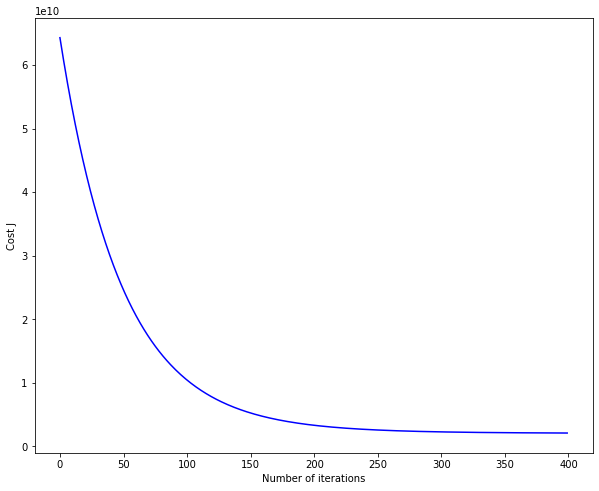

In [ ]:
plt.plot(list(range(0, len(J_history))), J_history, '-b')                         # Plot the data
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.show()